# Pesquisa Pecuária Municipal

Aluno: Jamesson Leandro Paiva Santos

## Introdução

A Pesquisa da Pecuária Municipal fornece informações sobre os efetivos da pecuária existentes no município na data de referência do levantamento, bem como a produção de origem animal, e o valor da produção durante o ano de referência. Os efetivos incluem bovinos, suínos, matrizes de suínos, galináceos, galinhas, codornas, equinos, bubalinos, caprinos e ovinos. A produção de origem animal, por sua vez, contempla a produção de leite, ovos de galinha, ovos de codorna, mel, lã bruta e casulos do bicho-da-seda; as quantidades de vacas ordenhadas e ovinos tosquiados; e a aquicultura, que engloba as produções da piscicultura, carcinocultura e malacocultura.

[Geometria município](https://basedosdados.org/dataset/49ace9c8-ae2d-454b-bed9-9b9492a3a642?table=b39609b4-ffb2-4b4f-a182-47b0d160037b)

[Geometria região](https://basedosdados.org/dataset/49ace9c8-ae2d-454b-bed9-9b9492a3a642?table=4b1c9db7-35a7-460e-ba38-336bb376f699)

## Configuração do ambiente e bibliotecas

In [1]:
import pandas as pd
import numpy as np
import gzip
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely import wkt
from plotnine import *

In [2]:
theme_set(theme_seaborn());

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
ONE_MILLION = 1_000_000

## Carregamento dos dados

In [5]:
def open_gzipped_csv(file_path: str) -> pd.DataFrame:
	with gzip.open(file_path, 'rt') as f:
		return pd.read_csv(f)


flock_df = open_gzipped_csv('data/br_ibge_ppm_efetivo_rebanhos.csv.gz')
aquaculture_df = open_gzipped_csv('data/br_ibge_ppm_producao_aquicultura.csv.gz')
animal_origin_prod_df = open_gzipped_csv('data/br_ibge_ppm_producao_origem_animal.csv.gz')
livestock_df = open_gzipped_csv('data/br_ibge_ppm_producao_pecuaria.csv.gz')

cities_df = open_gzipped_csv('data/br_bd_diretorios_brasil_municipio.csv.gz')

Carrega dados geográficos dos municípios, estados e regiões

In [6]:
regions_map_df = pd.read_csv("data/br_geobr_mapas_regiao.csv")
cities_map_df = pd.read_csv("data/br_geobr_mapas_municipio.csv")
states_map_df = pd.read_csv("data/br_geobr_mapas_uf.csv")

# Converter a coluna de geometria (WKT) para objetos geoespaciais
regions_map_df['geometria'] = regions_map_df['geometria'].apply(wkt.loads)
cities_map_df['geometria'] = cities_map_df['geometria'].apply(wkt.loads)
states_map_df['geometria'] = states_map_df['geometria'].apply(wkt.loads)

# Criar o GeoDataFrame
cities_gdf = gpd.GeoDataFrame(cities_map_df, geometry='geometria')
states_gdf = gpd.GeoDataFrame(states_map_df, geometry='geometria')
regions_gdf = gpd.GeoDataFrame(regions_map_df, geometry='geometria')

# Definir o sistema de coordenadas (CRS) - ajuste conforme necessário (geralmente EPSG:4326)
cities_gdf.set_crs(epsg=4326, inplace=True)
states_gdf.set_crs(epsg=4326, inplace=True)
regions_gdf.set_crs(epsg=4326, inplace=True);

In [7]:
# Adiciona nome do estado ao GeoDataFrame de estados
states_gdf = states_gdf.merge(
	cities_df.filter(['nome_uf', 'id_uf', 'sigla_uf']).drop_duplicates(),
	how='left',
	left_on='id_uf',
	right_on='id_uf'
).rename(columns={'sigla_uf_y': 'sigla_uf'})

# Adiciona nome da cidade e do estado ao GeoDataFrame de cidades
cities_gdf = cities_gdf.merge(
	cities_df.filter(['nome', 'id_municipio', 'nome_uf', 'sigla_uf']).drop_duplicates(),
	how='left',
	left_on='id_municipio',
	right_on='id_municipio'
).rename(columns={'nome_uf_y': 'nome_uf', 'sigla_uf_y': 'sigla_uf'})

Preenche cada um dos dataframes com os nomes das cidades e dos estados.

In [8]:
def fill_cities_names(df: pd.DataFrame) -> pd.DataFrame:
	df = df.merge(
		cities_df[['id_municipio', 'nome', 'nome_uf', 'nome_regiao', 'centroide']], 
		left_on='id_municipio', 
		right_on='id_municipio'
	)

	# df.drop(columns=['id_municipio'], inplace=True)
	df.rename(columns={'nome': 'municipio'}, inplace=True)

	return df

flock_df = fill_cities_names(flock_df)
aquaculture_df = fill_cities_names(aquaculture_df)
animal_origin_prod_df = fill_cities_names(animal_origin_prod_df)
livestock_df = fill_cities_names(livestock_df)

### Efetivo de rebanhos

In [9]:
flock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1368144 entries, 0 to 1368143
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   ano           1368144 non-null  int64 
 1   sigla_uf      1368144 non-null  object
 2   id_municipio  1368144 non-null  int64 
 3   tipo_rebanho  1368144 non-null  object
 4   quantidade    1368144 non-null  int64 
 5   municipio     1368144 non-null  object
 6   nome_uf       1368144 non-null  object
 7   nome_regiao   1368144 non-null  object
 8   centroide     1368144 non-null  object
dtypes: int64(3), object(6)
memory usage: 93.9+ MB


In [10]:
flock_df.head(1)

,ano,sigla_uf,id_municipio,tipo_rebanho,quantidade,municipio,nome_uf,nome_regiao,centroide
0,1978,RO,1100106,Bovino,12943,Guajará-Mirim,Rondônia,Norte,POINT(-64.537710733004 -11.3055098790143)


In [11]:
# Valores nulos
flock_df.isnull().sum().sort_values(ascending=False)

ano             0
sigla_uf        0
id_municipio    0
tipo_rebanho    0
quantidade      0
municipio       0
nome_uf         0
nome_regiao     0
centroide       0
dtype: int64

In [12]:
# Anos disponíveis (ordenado)
flock_df.ano.sort_values().unique()

array([1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021, 2022])

In [13]:
# Tipos de rebanhos
flock_df.tipo_rebanho.unique()

array(['Bovino', 'Equino', 'Caprino', 'Bubalino', 'Codornas',
       'Suíno - total', 'Galináceos - galinhas',
       'Suíno - matrizes de suínos'], dtype=object)

In [14]:
# Removendo anos anteriores a 1990
flock_df.query("ano >= 1990", inplace=True)

#### Total de rebanhos produzidos no Brasil

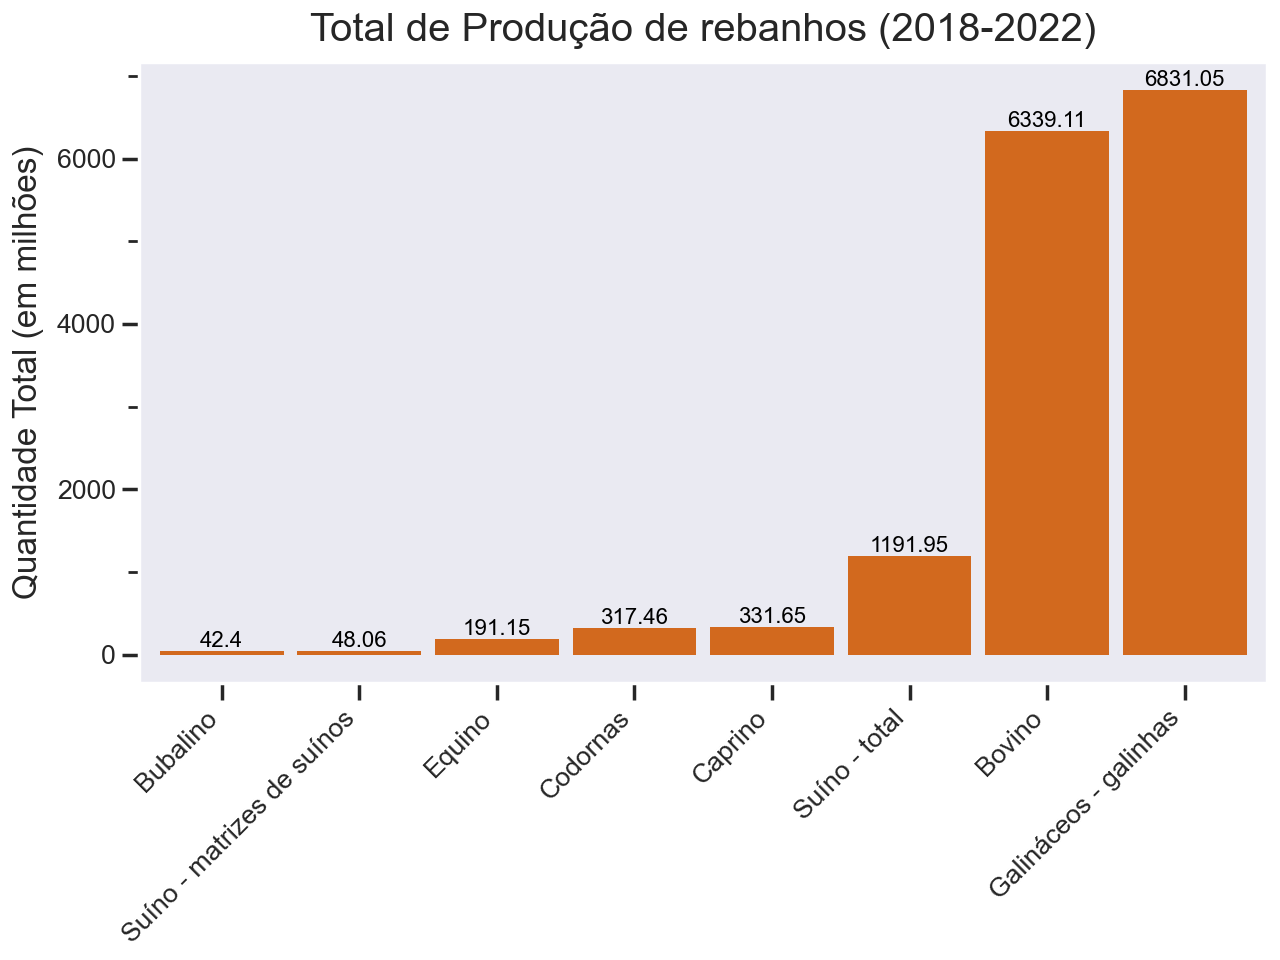

In [15]:
# Agrupa por 'tipo_rebanho' e soma as quantidades
flocks_by_type = (flock_df
	.groupby('tipo_rebanho')
	.agg({'quantidade': 'sum'})
	.assign(quantidade_milhoes = lambda _: _.quantidade / ONE_MILLION)
	.reset_index())

plot = (ggplot(flocks_by_type,
	aes(x='reorder(tipo_rebanho, quantidade_milhoes)', y='quantidade_milhoes'))
    + geom_bar(stat='identity', fill='chocolate')
    + geom_text(
        aes(label=flocks_by_type.quantidade_milhoes.round(2)),
        va='bottom',
        size=8
    )
    + theme(
      	axis_text_x=element_text(rotation=45, hjust=1),
        panel_grid_major=element_blank(),
    )
    # + scale_y_continuous(labels=lambda l: [f'{v}M' for v in l])
    + labs(
      	title='Total de Produção de rebanhos (2018-2022)',
		x='',
		y='Quantidade Total (em milhões)'
    )
)

plot.show()

O tipo de rebanho "Galináceos - galinhas" possui a maior quantidade, com mais de 1 bilhão somados, seguido da classe dos bovinos. Isso indica que galináceos representam uma parte significativa da produção total de rebanhos, possivelmente por serem um alimento básico e com alta demanda no mercado, enquanto que a produção de bovinos geralmente está associada tanto ao consumo de carne quanto à produção de leite, o que pode justificar o seu volume elevado.

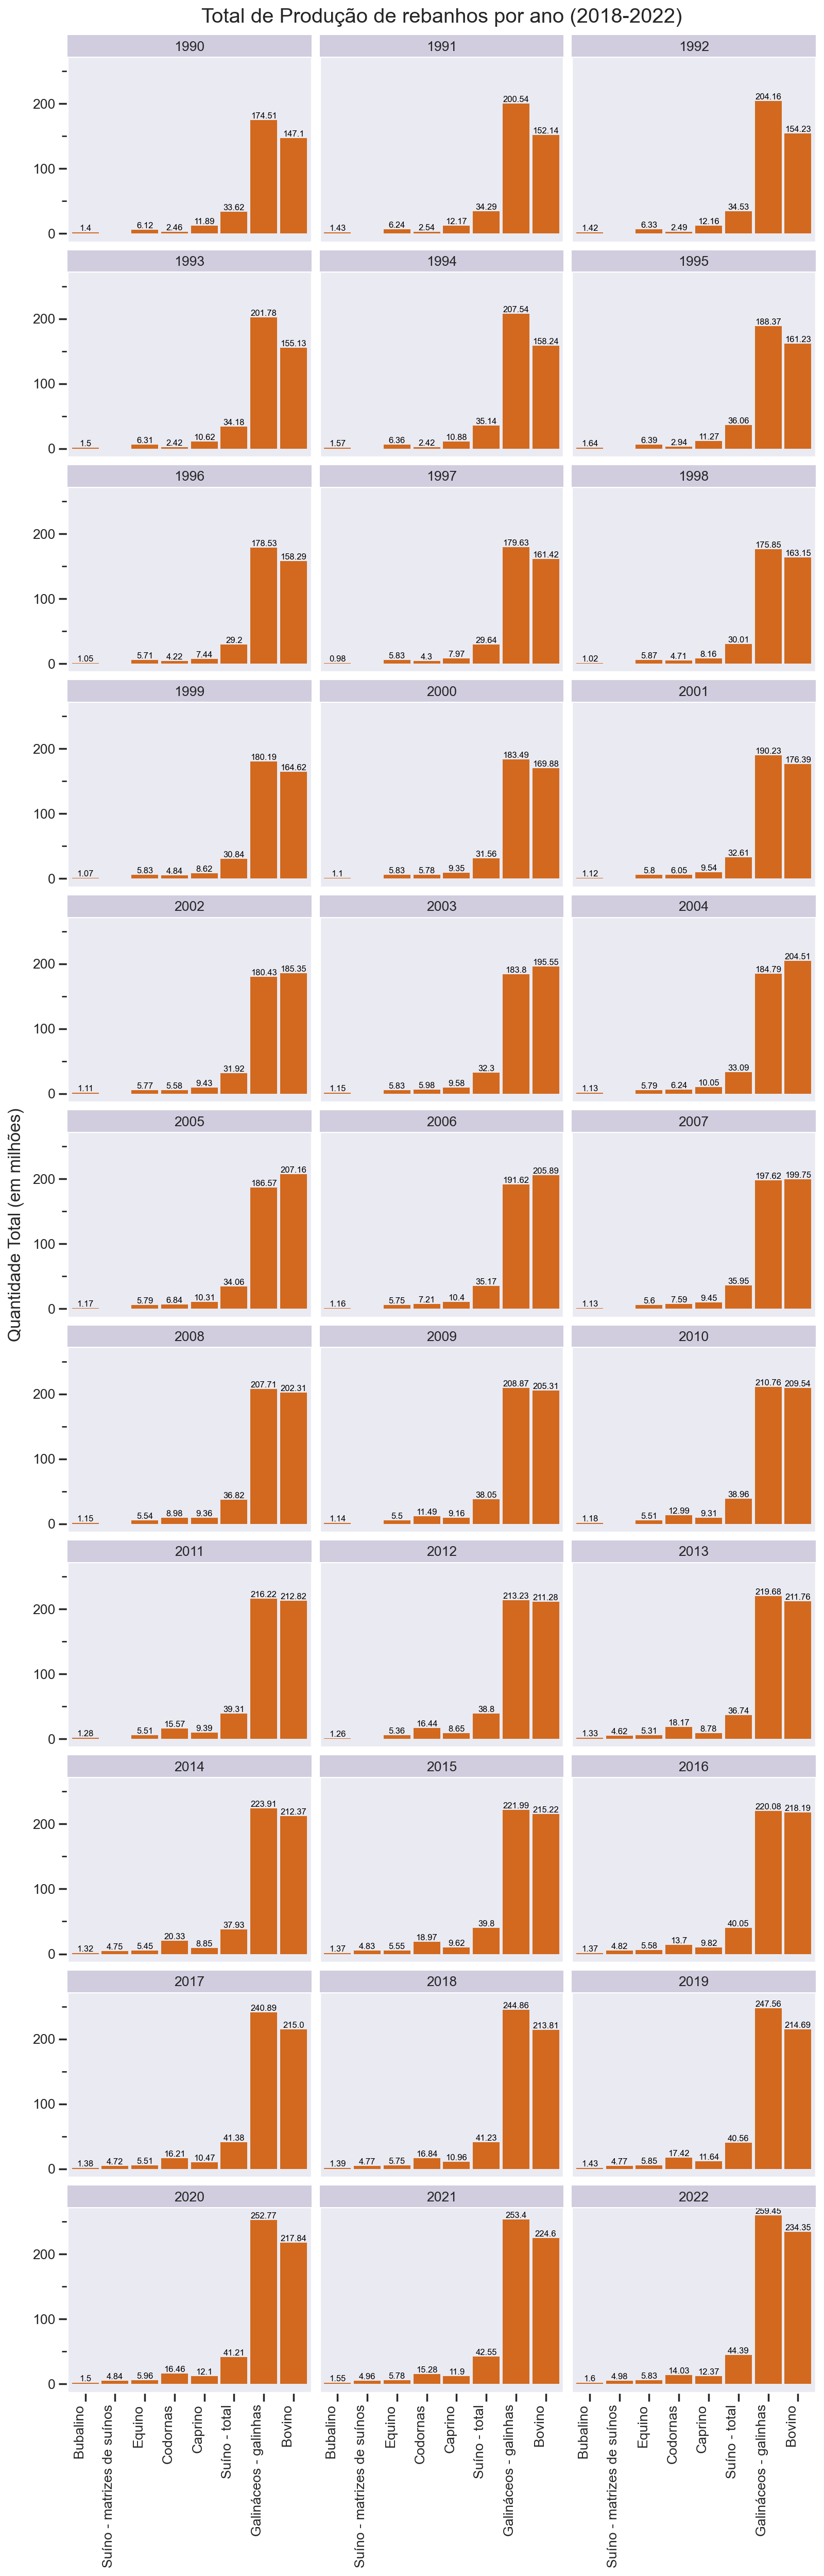

In [16]:
# Agrupando os dados por ano e tipo de rebanho
flocks_by_type_year = (
    flock_df
    .groupby(['ano', 'tipo_rebanho'])
    .agg({'quantidade': 'sum'})
    .assign(quantidade_milhoes=lambda _: _.quantidade / ONE_MILLION)
    .reset_index()
)

# Criando o gráfico com facet_wrap
plot = (ggplot(flocks_by_type_year,
	aes(x='reorder(tipo_rebanho, quantidade_milhoes)', y='quantidade_milhoes'))
	# Cria as barras
    + geom_bar(stat='identity', fill='chocolate')
    
    + theme(
        axis_text_x=element_text(rotation=90, hjust=1),
        panel_grid_major=element_blank(),
        figure_size=(8, 25)
    )

	# Adiciona os valores no topo das barras
    + geom_text(
        aes(label=flocks_by_type_year.quantidade_milhoes.round(2)),
        va='bottom',
        size=6
    )
    
	# Adiciona a separação por ano
    + facet_wrap('~ano', ncol=3)
    
	# Adiciona o título e os labels
    + labs(
        title='Total de Produção de rebanhos por ano (2018-2022)',
        x='',
        y='Quantidade Total (em milhões)'
    )
)

plot.show()

O gráfico acima mostra o mesmo comportamento observado ao longo de todo o período, alta produção de galináceos e bovinos, seguido de suínos e galinhas.

#### Produção de rebanhos por estado brasileiro (TOP 10)

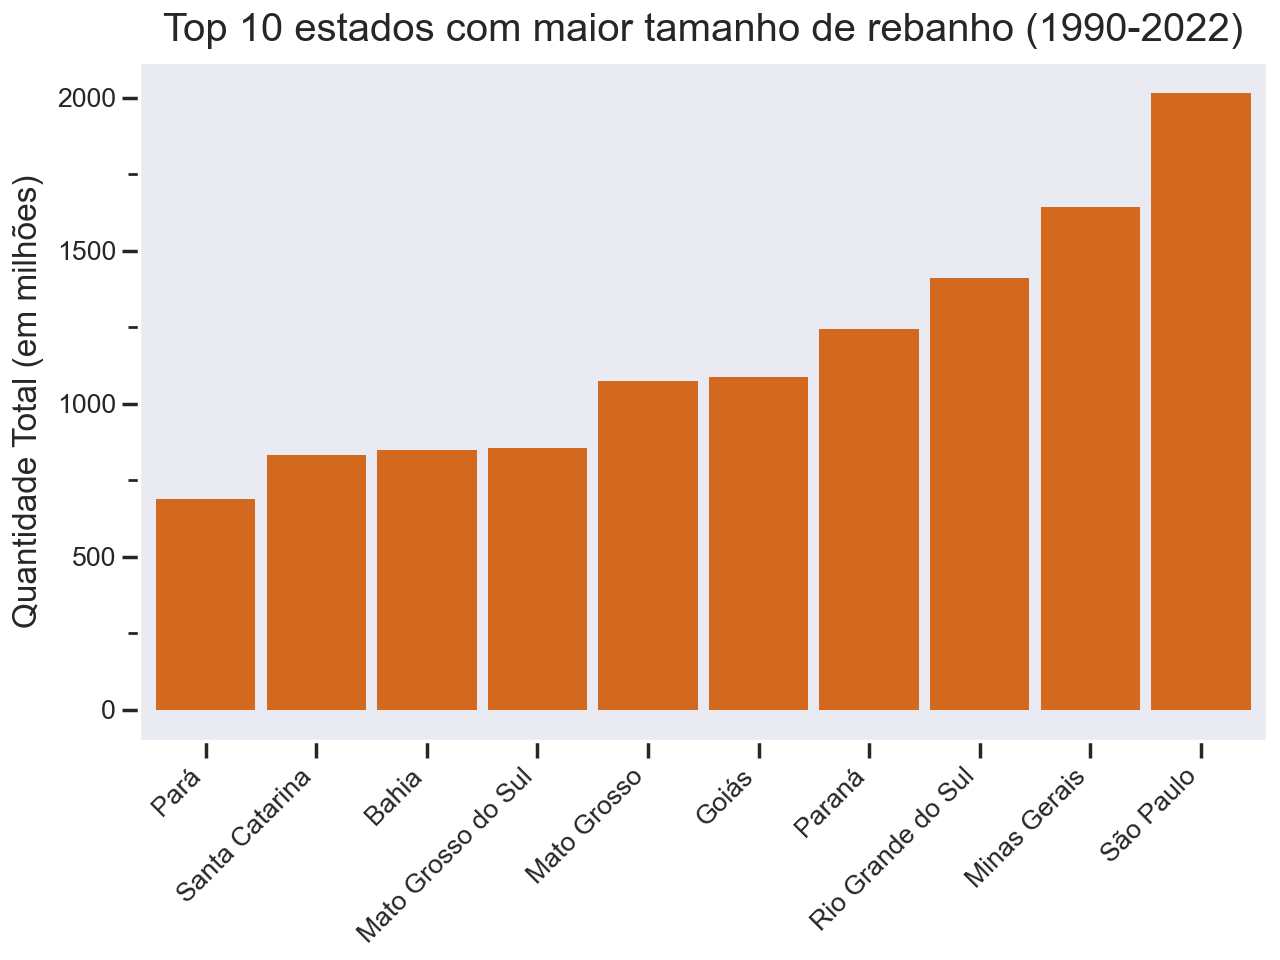

In [17]:
# Agrupa os dados por estado e calcula o total de rebanhos em cada estado
flock_top_states = (
    flock_df
    .groupby('nome_uf')
    .agg({'quantidade': 'sum'})
    .assign(quantidade_milhoes=lambda x: x.quantidade / ONE_MILLION)
    .reset_index()
    .sort_values(by='quantidade_milhoes', ascending=False)
    .head(10)  # Seleciona os 10 estados com maior quantidade
)

plot = (
    ggplot(flock_top_states, aes(x='reorder(nome_uf, quantidade_milhoes)', y='quantidade_milhoes'))
    + geom_bar(stat='identity', fill='chocolate')
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        panel_grid_major=element_blank(),
        # figure_size=(10, 6)
    )
    + labs(
        title='Top 10 estados com maior tamanho de rebanho (1990-2022)',
        x='',
        y='Quantidade Total (em milhões)'
    )
)

plot.show()

Este gráfico exibe os 10 estados brasileiros com o maior tamanho de rebanho ao longo do período de 2018 a 2022. O estado de São Paulo se destaca significativamente, liderando a produção de rebanhos com uma diferença visível em relação aos outros estados. Minas Gerais, Mato Grosso e Goiás, estados do centro-oeste brasileiro, também aparecem com grandes quantidades de rebanho. São estados cujas economias são fortemente baseadas na agropecuária, com vastas áreas de pastagem e clima propício para a criação de gado, especialmente bovinos. Paraná, Rio Grande do Sul e Santa Catarina, estados do sul do Brasil, também se destacam na produção de rebanhos. Esses estados têm uma tradição pecuária forte, com clima favorável para a criação de animais.

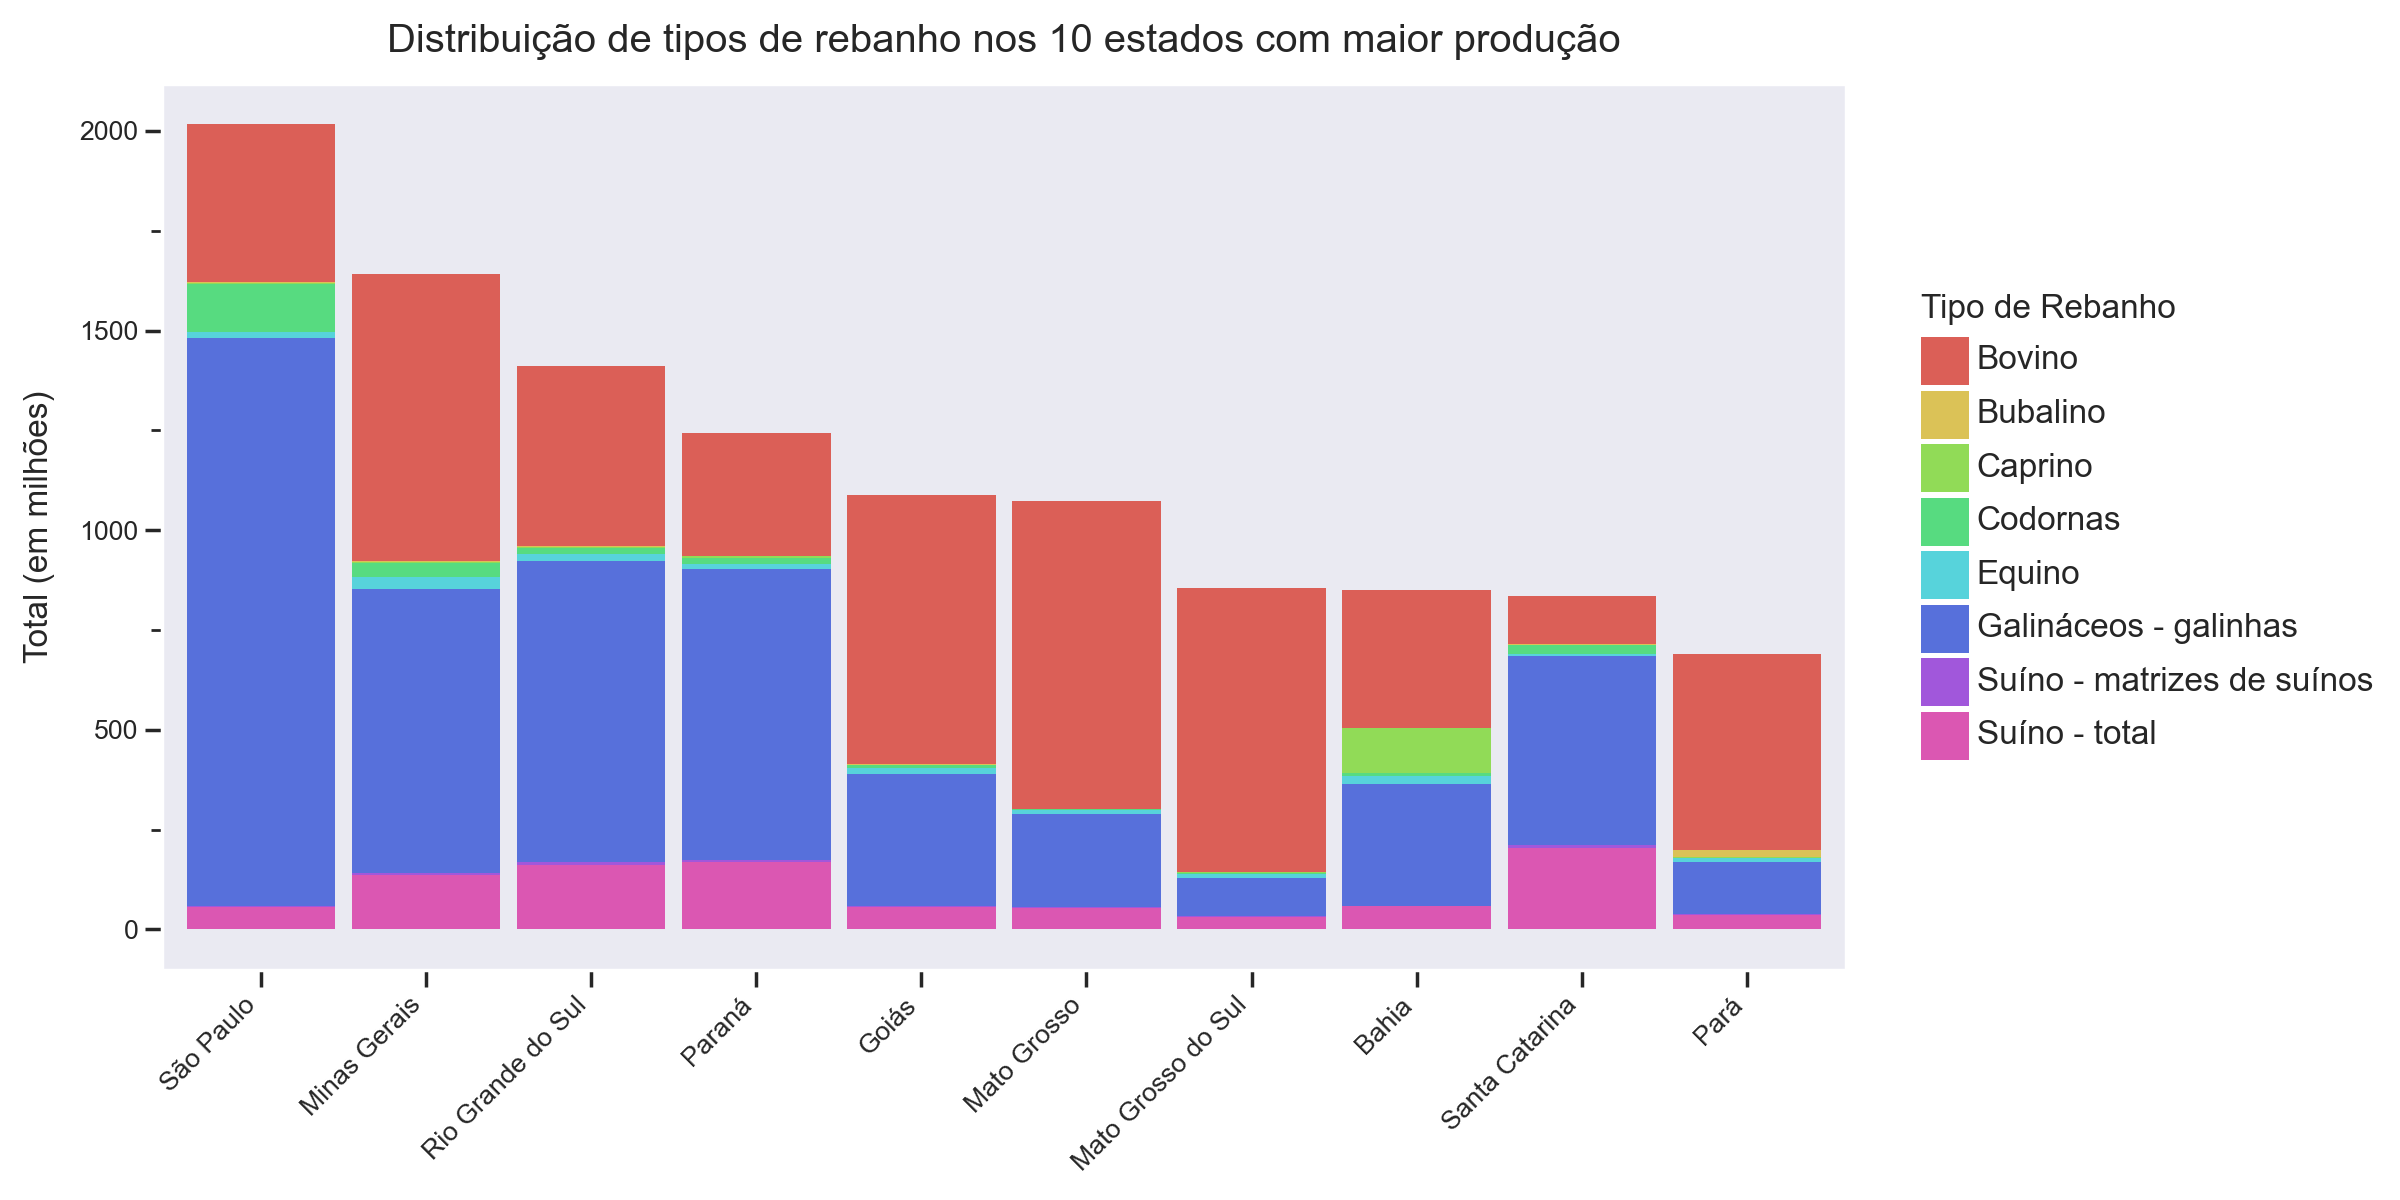

In [18]:
# Agrupa por estado e tipo de rebanho, somando as quantidades
df_grouped = (
    flock_df
    .groupby(["nome_uf", "tipo_rebanho"])
    .agg(quantidade=("quantidade", "sum"))
    .reset_index()  # Transforma índices em colunas normais
    .assign(quantidade_milhoes=lambda df: df.quantidade / ONE_MILLION)
)

# Calcula o total de rebanho para cada estado e ordena
state_totals = (df_grouped
    .groupby("nome_uf")
    .agg(total_estado=("quantidade_milhoes", "sum"))
    .sort_values("total_estado", ascending=False)
    .reset_index()  # Garante que o índice seja resetado
    .head(10)       # Seleciona os 10 estados com maior produção
)

# Reordena os estados no DataFrame principal com base no total
df_grouped = (
    df_grouped.merge(state_totals, on="nome_uf")
    .assign(
        nome_uf=lambda df: pd.Categorical(df.nome_uf, categories=state_totals.nome_uf, ordered=True)
    )
)

# Cria o gráfico de barras empilhadas ordenado
plot = (
    ggplot(df_grouped, aes(x="nome_uf", y="quantidade_milhoes", fill="tipo_rebanho"))
    + geom_bar(stat="identity")
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(12, 6),
        panel_grid_major=element_blank()
    )
    + labs(
        title="Distribuição de tipos de rebanho nos 10 estados com maior produção",
        x="",
        y="Total (em milhões)",
        fill="Tipo de Rebanho"
    )
)

plot.show()

O gráfico mostra a distribuição dos tipos de rebanho nos 10 estados brasileiros com maior produção total ao longo do período de 2018 a 2022. Observa-se que o estado de São Paulo possui a maior quantidade total, com um destaque significativo para o rebanho de **Galináceos - galinhas**, que representa a maior parte da produção de rebanho do estado.

Nos estados de Mato Grosso, Goiás e Minas Gerais, o rebanho bovino representa a maior proporção. Isso reflete a especialização da região Centro-Oeste na pecuária bovina. Mato Grosso, em particular, é conhecido por sua forte atuação na pecuária de corte, atendendo tanto ao mercado interno quanto ao externo, o que justifica o destaque do rebanho bovino.

Dos 10 maiores rebanhos do país, nota-se também como o estado do Pará se destaca com uma expressiva quantidade de rebanho bovino, o que pode sugerir que a região tem um grande potencial para a produção de carne bovina.

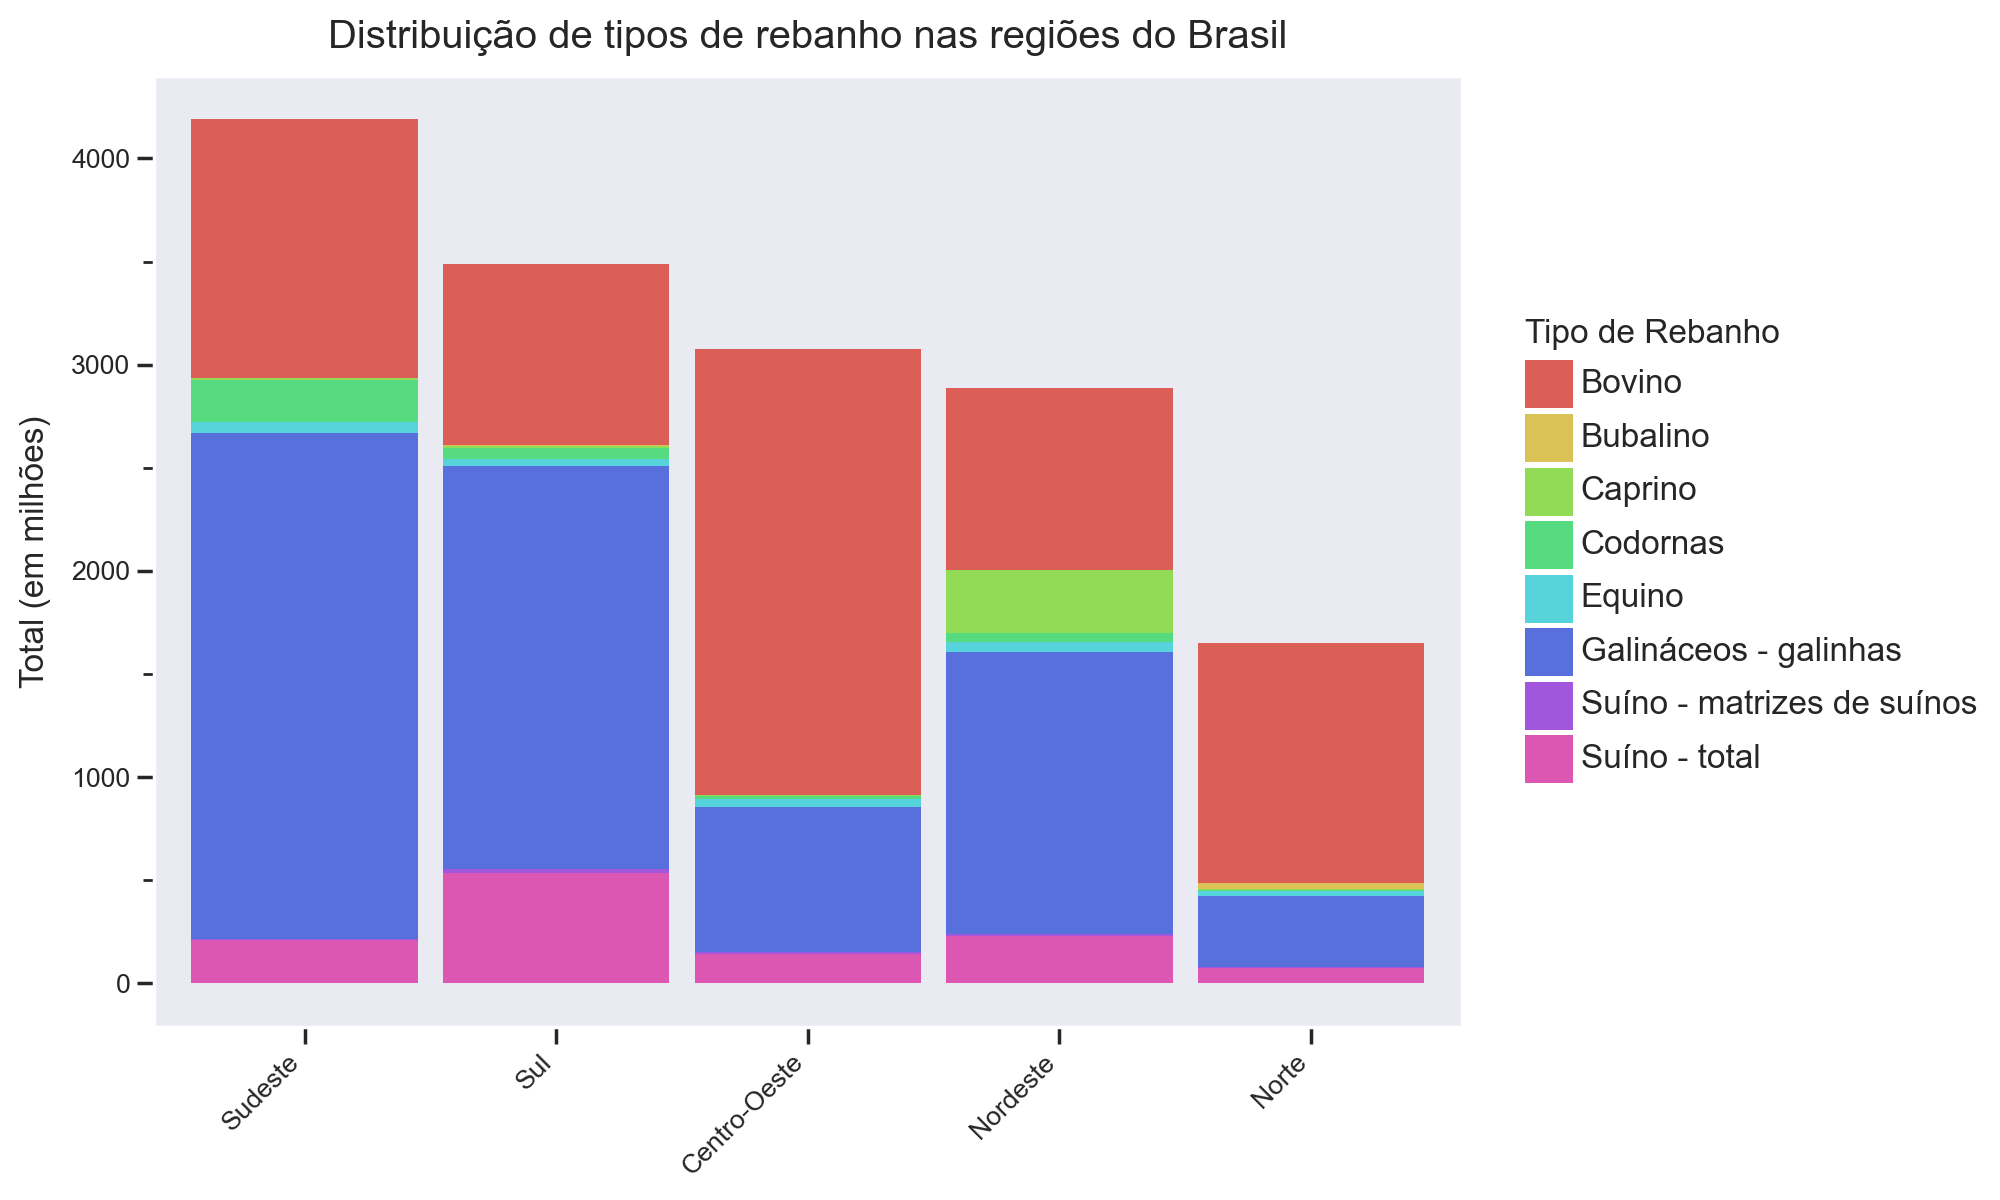

In [19]:
# Agrupa por região e tipo de rebanho, somando as quantidades
df_grouped = (
    flock_df
    .groupby(["nome_regiao", "tipo_rebanho"])
    .agg(quantidade=("quantidade", "sum"))
    .reset_index()  # Transforma índices em colunas normais
    .assign(quantidade_milhoes=lambda df: df.quantidade / ONE_MILLION)
)

# Calcula o total de rebanho para cada região e ordena
state_totals = (df_grouped
                .groupby("nome_regiao")
                .agg(total_estado=("quantidade_milhoes", "sum"))
                .sort_values("total_estado", ascending=False)
                .reset_index()  # Garante que o índice seja resetado
                # .head(10)       # Seleciona os 10 estados com maior produção
                )

# Reordena os estados no DataFrame principal com base no total
df_grouped = (
    df_grouped.merge(state_totals, on="nome_regiao")
    .assign(
        nome_regiao=lambda df: pd.Categorical(
            df.nome_regiao, categories=state_totals.nome_regiao, ordered=True)
    )
)

# Cria o gráfico de barras empilhadas ordenado
plot = (
    ggplot(df_grouped, aes(x="nome_regiao", y="quantidade_milhoes", fill="tipo_rebanho"))
    + geom_bar(stat="identity")
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(10, 6),
        panel_grid_major=element_blank()
    )
    + labs(
        title="Distribuição de tipos de rebanho nas regiões do Brasil",
        x="",
        y="Total (em milhões)",
        fill="Tipo de Rebanho"
    )
)

plot.show()

**TODO**: Adicionar análise sobre a produção de rebanhos por estado brasileiro.

#### Avaliação temporal dos rebanhos brasileiros

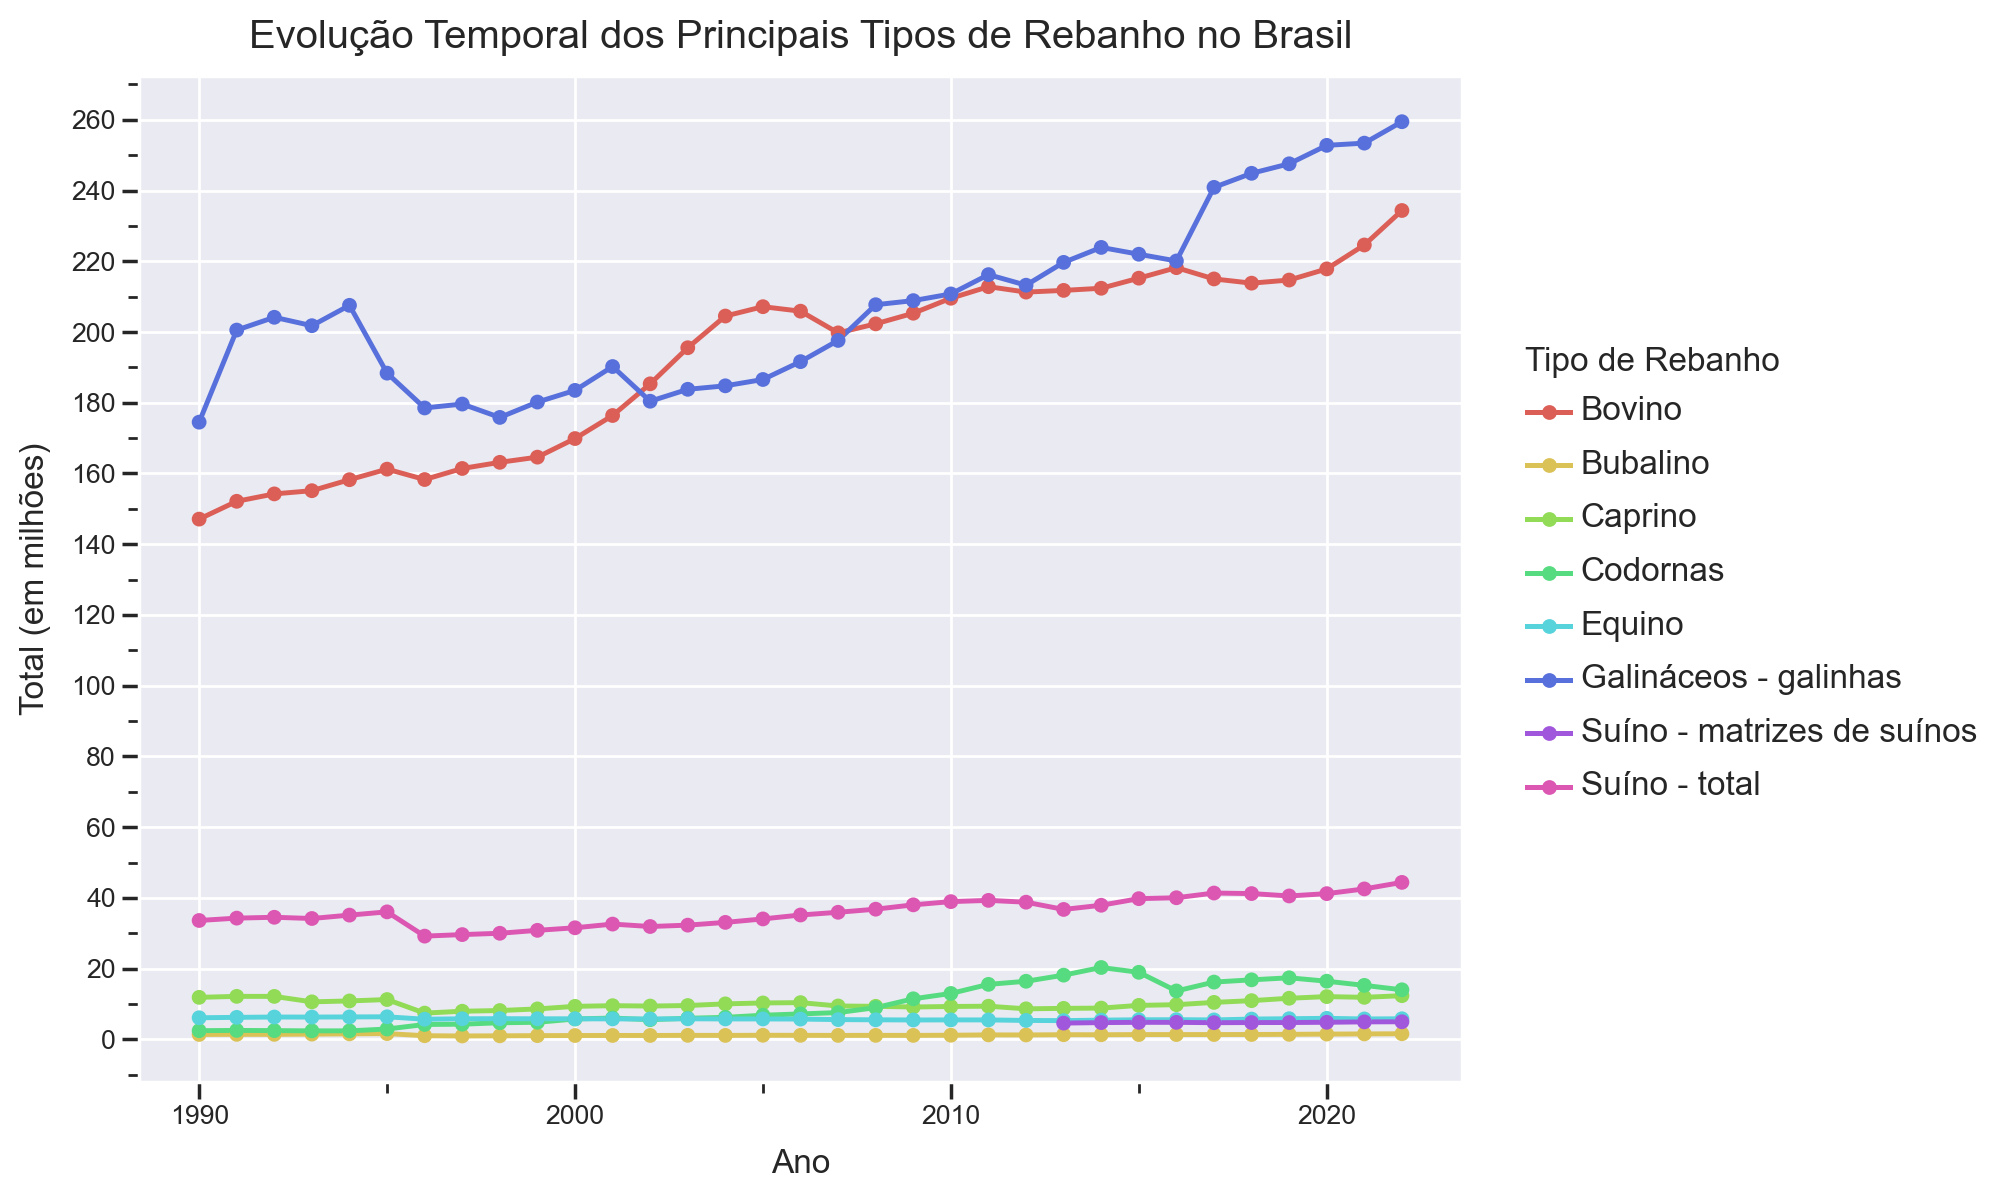

In [20]:
# Agrupa os dados por ano e tipo de rebanho, somando as quantidades
df_temporal = (
    flock_df
    .groupby(["ano", "tipo_rebanho"])
    .agg(quantidade=("quantidade", "sum"))
    .reset_index()
    .assign(quantidade_milhoes=lambda _: _.quantidade / ONE_MILLION)
)

# Cria o gráfico de linhas para observar a evolução ao longo dos anos
plot = (
    ggplot(df_temporal, aes(x="ano", y="quantidade_milhoes", color="tipo_rebanho"))
    + geom_line(size=1)  # Linha para mostrar a evolução ao longo dos anos
    + geom_point(size=2)    # Pontos para destacar cada ano
    + scale_y_continuous(breaks=range(0, int(df_temporal.quantidade_milhoes.max()) + 20, 20))
    + theme(
        axis_text_x=element_text(hjust=2),
        figure_size=(10, 6),
    )
    + labs(
        title="Evolução Temporal dos Principais Tipos de Rebanho no Brasil",
        x="Ano",
        y="Total (em milhões)",
        color="Tipo de Rebanho"
    )
)

plot.show()

O rebanho de bovinos foi o que mais cresceu nos últimos anos. Vamos dar uma olhada mais de perto nesse crescimento.

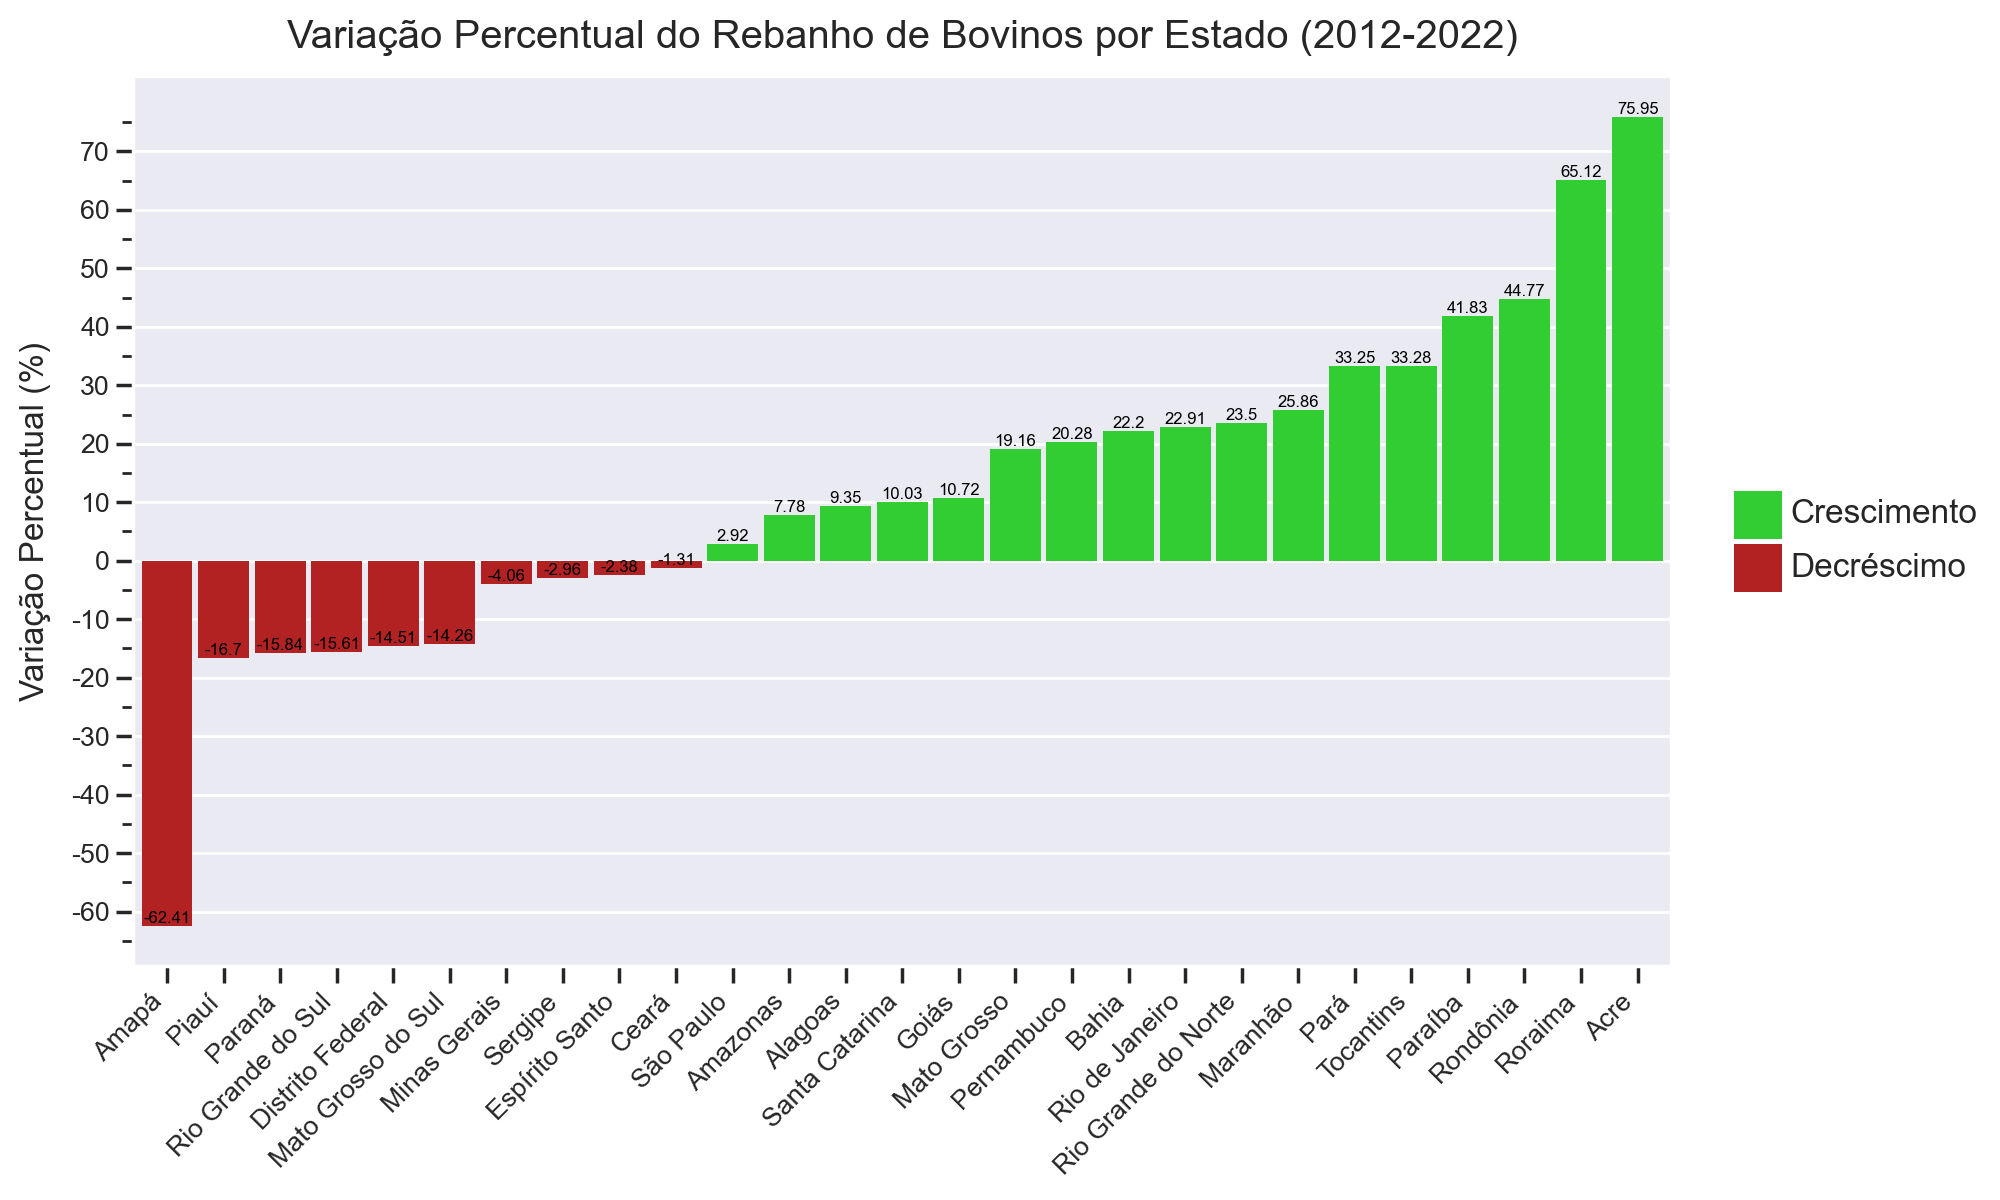

In [21]:
# Filtra os dados para incluir apenas o rebanho de bovinos
df_bovino = flock_df.query("tipo_rebanho == 'Bovino'")

# Agrupa por estado e ano, somando as quantidades
df_bovino_agg = (
    df_bovino
    .groupby(["nome_uf", "ano"])
    .agg(quantidade=("quantidade", "sum"))
    .reset_index()
)

# Obtém os valores de 2012 e 2022 para cada estado
df_growth = (df_bovino_agg
    .query("ano in [2012, 2022]")
    .pivot_table(index="nome_uf", columns="ano", values="quantidade")
    .reset_index()
    .assign(crescimento_percentual=lambda df: ((df[2022] - df[2012]) / df[2012]) * 100)
    .assign(cor=lambda df: df.crescimento_percentual.apply(lambda x: 'Crescimento' if x > 0 else 'Decréscimo'))
)

# Ordena pelo variação percentual
df_growth_sorted = df_growth.sort_values(
    by="crescimento_percentual", ascending=False)

# Cria o gráfico de barras para a variação percentual
plot = (
    ggplot(df_growth_sorted, aes(
        x="reorder(nome_uf, crescimento_percentual)", y="crescimento_percentual", fill="cor"))
    + geom_bar(stat="identity")
    + scale_y_continuous(breaks=range(-80, 80, 10))
    + scale_fill_manual(values={"Crescimento": "limegreen", "Decréscimo": "firebrick"})
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(10, 6),
        panel_grid_major_x=element_blank(),
    )
    + labs(
        title="Variação Percentual do Rebanho de Bovinos por Estado (2012-2022)",
        x="",
        y="Variação Percentual (%)",
        fill="",
    )
    + geom_text(
        aes(label=df_growth_sorted.crescimento_percentual.round(2)),
		va="bottom",
		size=6,
	)
)

plot.show()

O gráfico apresenta a variação percentual do rebanho de bovinos entre 2018 e 2022 nos estados brasileiros, destacando os estados que tiveram crescimento (barras verdes) e decréscimo (barras vermelhas). Essa análise revela tendências regionais e mudanças significativas na pecuária brasileira durante o período analisado.

Os estados com maior crescimento percentual no rebanho de bovinos são o Acre, Roraima e Tocantins, com aumentos superiores a 25%, liderados pelo Acre com 40,31%. Esses números podem refletir políticas de incentivo ao setor agropecuário nessas regiões, aumento da área de pastagens ou investimentos em infraestrutura e tecnologia para expandir a produção. A região Norte, como evidenciado por estados como Roraima, Acre e Rondônia, mostra uma tendência de expansão da pecuária, possivelmente associada à disponibilidade de terras e ao aumento da demanda por carne bovina no mercado interno e externo.

Por outro lado, estados como Paraná (-14,58%) e Mato Grosso do Sul (-11,79%) apresentaram os maiores decréscimos percentuais. Esses resultados podem estar relacionados a fatores econômicos, ambientais ou até mudanças no uso da terra, como a conversão de áreas antes destinadas à pecuária para outras atividades agrícolas, como o cultivo de soja ou milho, que têm forte presença nessas regiões. Além disso, questões climáticas ou sanitárias, como epidemias que afetam os rebanhos, podem ter contribuído para essa redução.

O Sudeste e o Sul, como São Paulo e Santa Catarina, mostram crescimentos modestos, enquanto estados do Centro-Oeste, como Mato Grosso e Goiás, continuam com um crescimento mais expressivo, refletindo sua importância consolidada como polos pecuários do Brasil. Esses estados possuem infraestrutura mais robusta e acesso facilitado a mercados consumidores e exportações.

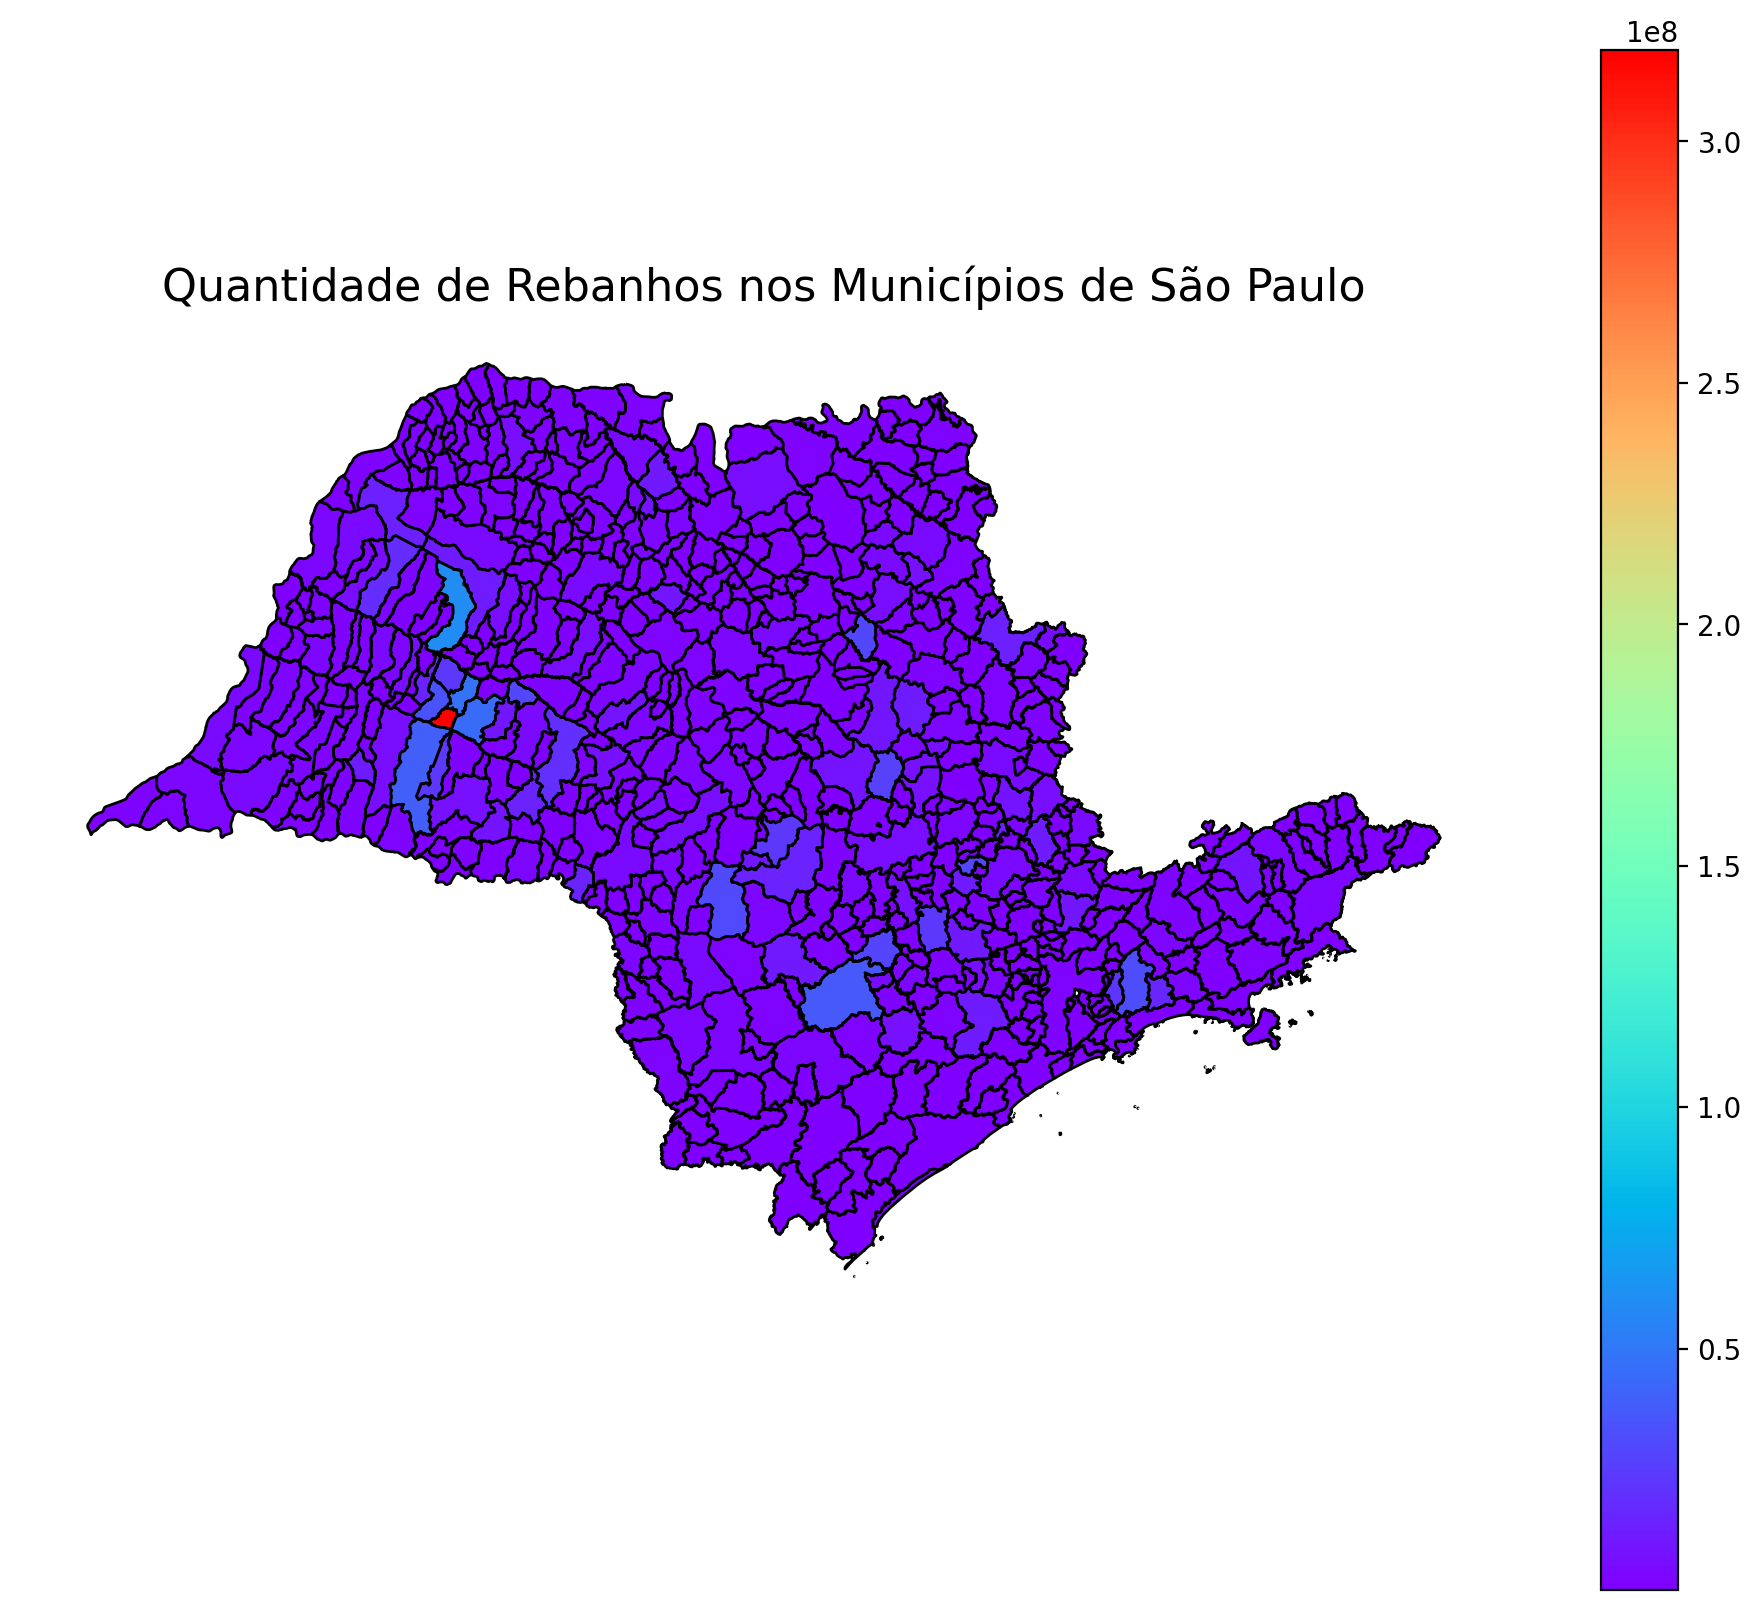

In [22]:
# Filtrar os municípios do estado de São Paulo
gdf_sp = cities_gdf.query('sigla_uf == "SP"')

# Agrupar o DataFrame de rebanhos por município e calcular o total de rebanhos
df_rebanhos_municipio = (flock_df
    .groupby('id_municipio')
    .agg(quantidade_total=('quantidade', 'sum'))
    .reset_index()
)

# Unir os dados de rebanhos com o GeoDataFrame dos municípios de São Paulo
gdf_sp_rebanhos = gdf_sp.merge(
    df_rebanhos_municipio, left_on='id_municipio', right_on='id_municipio', how='left')

# Plotar o mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_sp_rebanhos.plot(
    column='quantidade_total',  # Coluna de dados para a escala de cor
    cmap='rainbow',  # Esquema de cores
    legend=True,
    ax=ax,
    edgecolor='black'
)

# Personalizar o gráfico
ax.set_title('Quantidade de Rebanhos nos Municípios de São Paulo', fontsize=16)
ax.axis('off')  # Remove os eixos
plt.show()

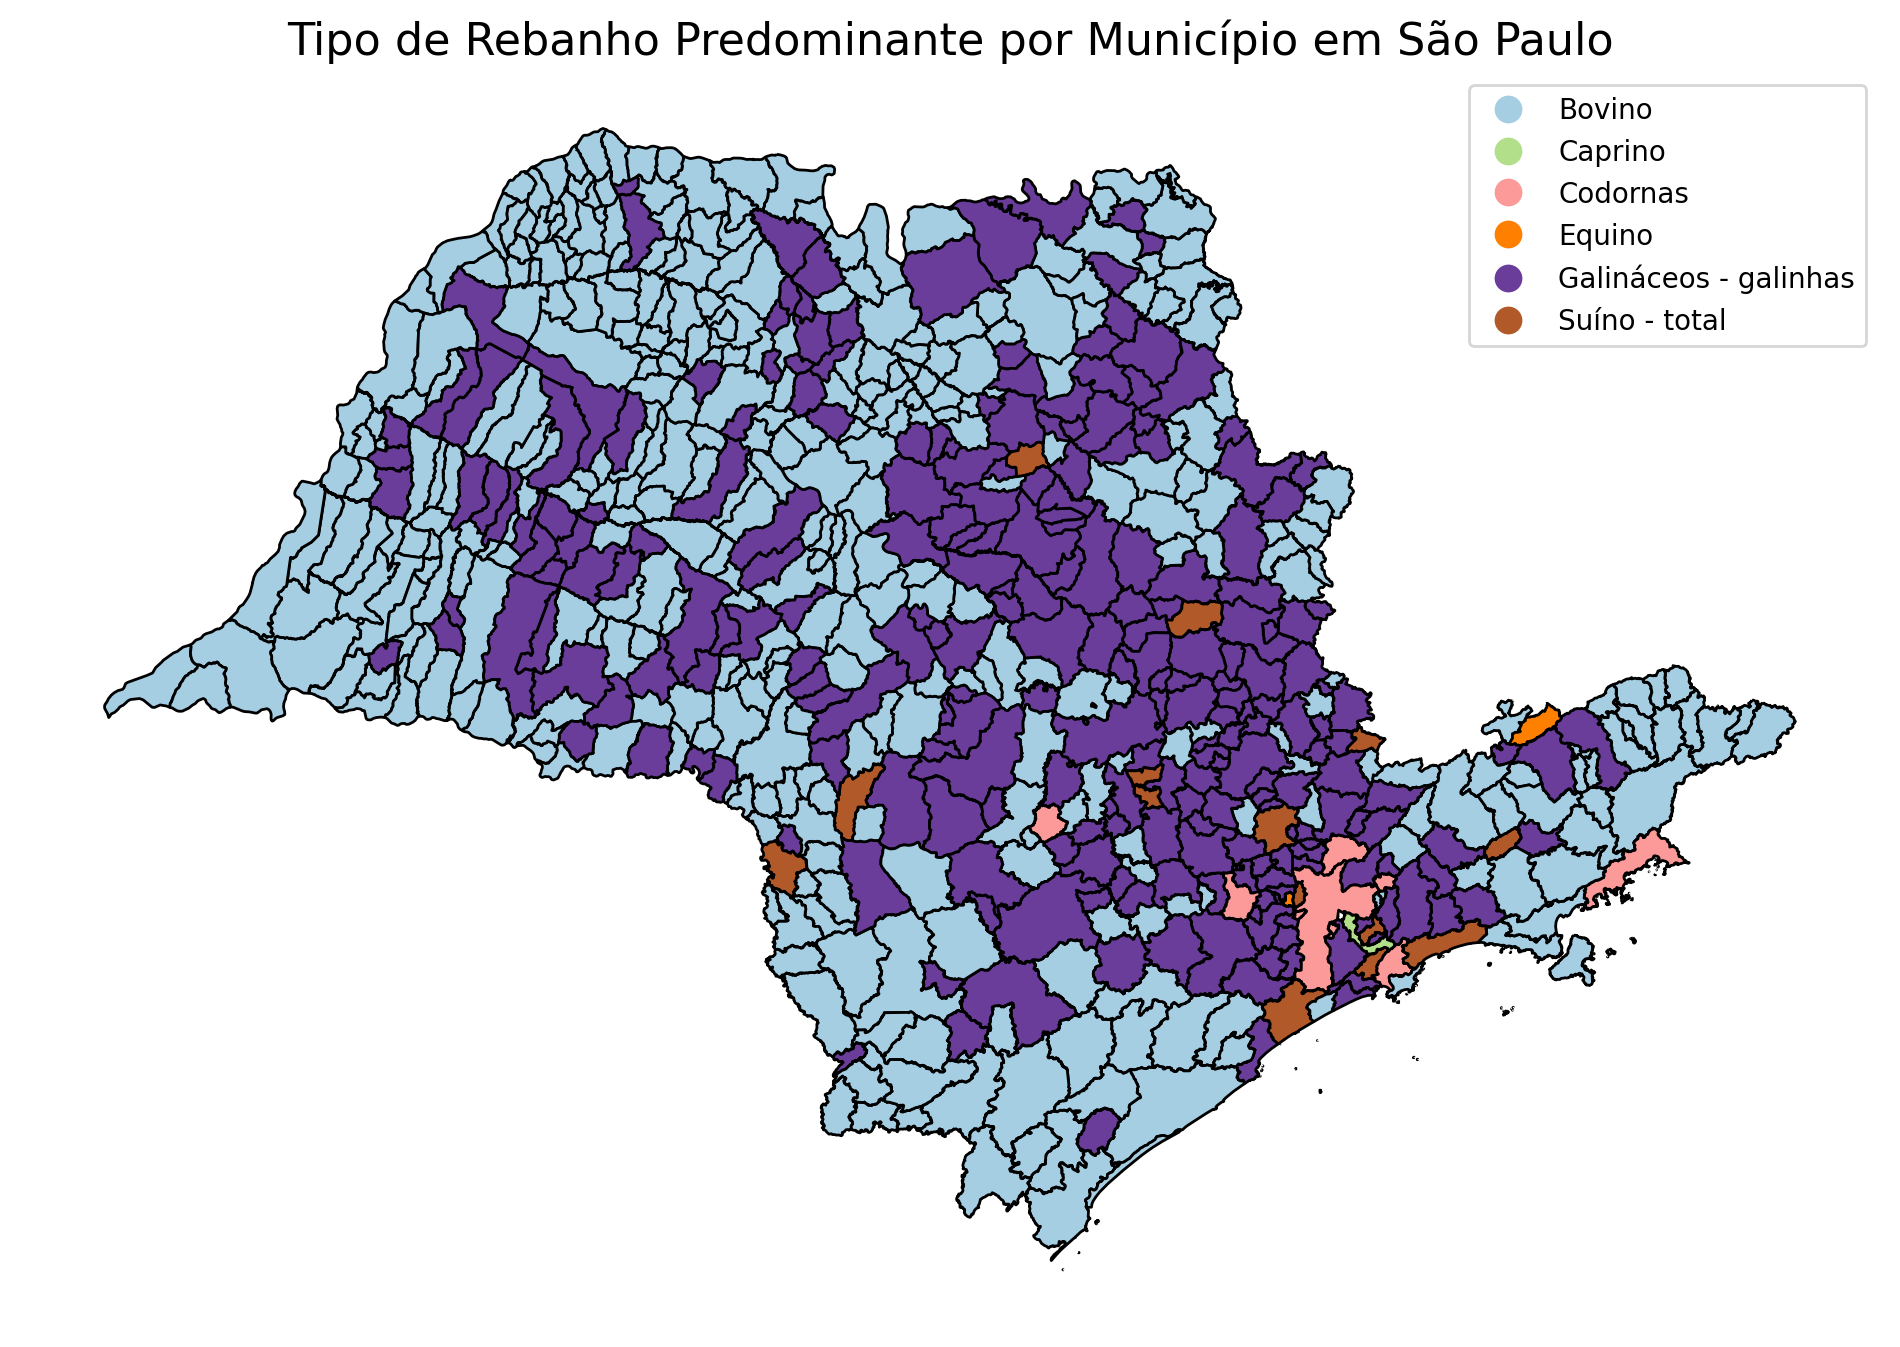

In [23]:
# Filtrar os municípios do estado de São Paulo
gdf_sp = cities_gdf.query("sigla_uf == 'SP'")

# Identificar o tipo de rebanho predominante por município
df_rebanhos_predominantes = (
    flock_df.groupby(['municipio', 'tipo_rebanho'])
    .agg(quantidade_total=('quantidade', 'sum'))
    .reset_index()
    .sort_values(by=['municipio', 'quantidade_total'], ascending=False)
    # Manter apenas o rebanho com maior quantidade por município
    .drop_duplicates(subset='municipio')
)

# Unir os dados com o GeoDataFrame dos municípios de São Paulo
gdf_sp_rebanhos_predominantes = gdf_sp.merge(
    df_rebanhos_predominantes, left_on='nome', right_on='municipio', how='left'
)

# Plotar o mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_sp_rebanhos_predominantes.plot(
    column='tipo_rebanho',  # Coluna para categorias de rebanho
    cmap='Paired',  # Colormap categórico
    legend=True,
    ax=ax,
    edgecolor='black'
)

# Personalizar o gráfico
ax.set_title('Tipo de Rebanho Predominante por Município em São Paulo', fontsize=16)
ax.axis('off')  # Remove os eixos
plt.show()

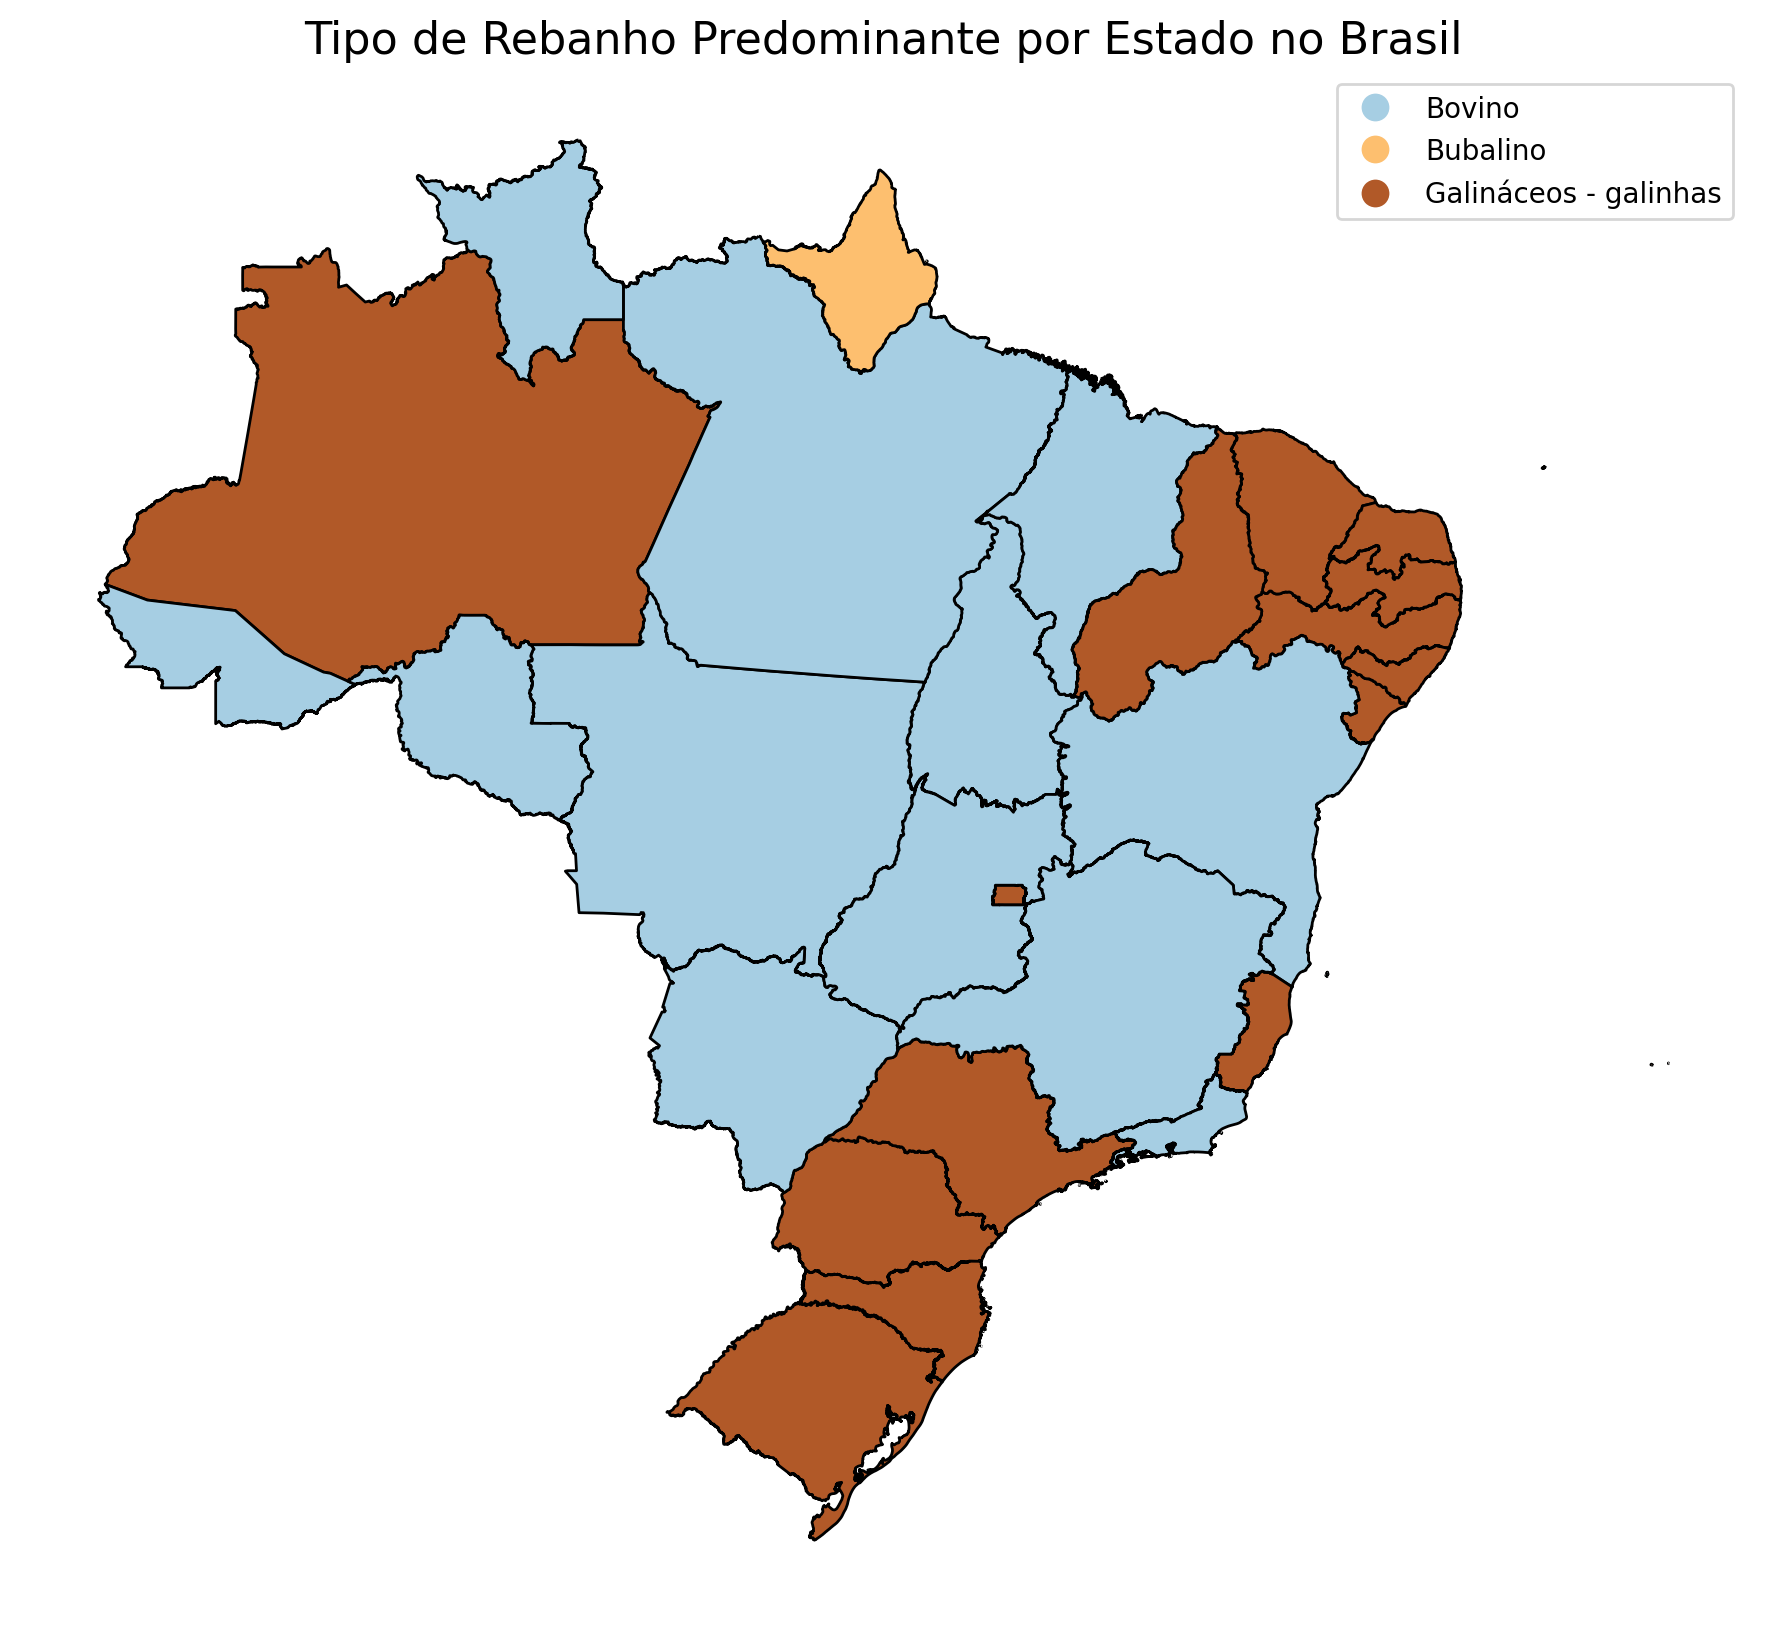

In [24]:
# Identificar o tipo de rebanho predominante por estado
df_rebanhos_estado = (flock_df
    .groupby(['sigla_uf', 'tipo_rebanho'])
    .agg(quantidade_total=('quantidade', 'sum'))
    .reset_index()
    .sort_values(by=['sigla_uf', 'quantidade_total'], ascending=False)
    # Manter apenas o rebanho com maior quantidade por estado
    .drop_duplicates(subset='sigla_uf')
)

# Unir os dados com o GeoDataFrame dos estados
gdf_estados_rebanhos = states_gdf.merge(
    df_rebanhos_estado, left_on='sigla_uf', right_on='sigla_uf', how='left'
)

# Plotar o mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_estados_rebanhos.plot(
    column='tipo_rebanho',  # Coluna para categorias de rebanho
    cmap='Paired',  # Colormap categórico
    legend=True,
    ax=ax,
    edgecolor='black'
)

# Personalizar o gráfico
ax.set_title('Tipo de Rebanho Predominante por Estado no Brasil', fontsize=16)
ax.axis('off')  # Remove os eixos
plt.show()

### Aquicultura

In [25]:
aquaculture_df.isnull().sum().sort_values(ascending=False)

ano             0
sigla_uf        0
id_municipio    0
produto         0
quantidade      0
valor           0
municipio       0
nome_uf         0
nome_regiao     0
centroide       0
dtype: int64

In [26]:
aquaculture_df.produto.unique()

array(['Carpa', 'Truta', 'Dourado', 'Lambari', 'Alevinos', 'Camarão',
       'Pirarucu', 'Tambaqui', 'Tilápia', 'Matrinxã', 'Tucunaré',
       'Pirapitinga', 'Outros peixes', 'Pacu e patinga',
       'Traíra e trairão', 'Tambacu, tambatinga', 'Sementes de moluscos',
       'Curimatã, curimbatá', 'Ostras, vieiras e mexilhões',
       'Piau, piapara, piauçu, piava', 'Larvas e pós-larvas de camarão',
       'Jatuarana, piabanha e piracanjuba',
       'Pintado, cachara, cachapira e pintachara, surubim'], dtype=object)